In [2]:
import pickle
import os
import numpy as np
from PIL import Image
from matplotlib import image
from matplotlib import pyplot as plt
import pandas as pd
import copy
from matplotlib.patches import Circle
import matplotlib.patches as patches


Bad key "text.kerning_factor" on line 4 in
C:\Users\Asus\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#We must define function to utilize in sorted function.
#Because our name of image do not sorted with default sorted function.
#This key_func function take a image name and give us only number charcter.
#For example:input:0_webcam_1.jpg
#            output:01
#Thus, we sorted image name with key_func rule.

def key_func(file):
    numbers=[int(f)for f in file.split("_") if f.isdigit()]
    merge = int("".join([str(i) for i in numbers]))
    return merge

In [3]:
# Our aim with this code block that Each image has joint points and we read this files and append to joint_list for utilize at next steps

joint_list=[]                                          #create empty list to append our joint points
for root, dirs, files in os.walk(r"..\projections_2d"):#iterate over projections_2d folder and find all folder root,folder name in folder projections_2d and files name in projections_2d
     for file in sorted(files,key=key_func):           #sorted files name by key_func
        filename = os.path.join(root, file)            #Put together file name and file root to create filename that is path of the file
        joint_list.append(np.genfromtxt(filename,delimiter =' ', usecols = [1,2])) #open file and append to joint_list
joint_arr=np.array(joint_list)                         #convert list to numpy array 
del joint_list                                         #not need joint_list. we can delete it
print(joint_arr.shape)                                 #print array shape
print(type(joint_arr))                                 #print array type

(2832, 21, 2)
<class 'numpy.ndarray'>


In [4]:
#Each image has bounding box and we read this files and append to bounding_list for utilize at next steps

bounding_list=[]                                       #create empty list to append our bounding box
for root, dirs, files in os.walk(r"..\bounding_boxes"):#iterate over bounding_boxes folder and find all folder root,folder name in folder bounding_boxes and files name in bounding_boxes
     for file in sorted(files,key=key_func):           #sorted files name by key_func
        filename = os.path.join(root, file)            #Put together file name and file root to create filename that is path of the file
        bounding_list.append(np.genfromtxt(filename,delimiter =' ', usecols = [1]))  #open file and append to bounding_list
bounding_arr=np.array(bounding_list)                   #convert list to numpy array 
del bounding_list                                      #not need bounding_list. we can delete it
bounding_arr=bounding_arr.reshape((2832,4,1))          #convert (2832,4,) to (2832,4,1) to reach 3 dimension
print(bounding_arr.shape)                              #print array shape
print(type(bounding_arr))                              #print array type

(2832, 4, 1)
<class 'numpy.ndarray'>


In [5]:
#Read each image and append to image_list for utilize at next steps.

image_list=[]                                            #create empty list to append our images
for root, dirs, files in os.walk(r"..\annotated_frames"):#iterate over annotated_frames folder and find all folder root,folder name in folder annotated_frames  and image name in annotated_frames
     for file in filter(lambda x: x[-4:] == '.jpg', sorted(files,key=key_func)):#sorted image name by key_func
        filename = os.path.join(root, file)         #Put together image name and image root to create filename that is path of the image
        image=Image.open(filename)                  #open image
        image_list.append(np.array(image))          #append image to image_list
        image.close()                               #close image
image_arr=np.array(image_list)                      #convert list to numpy array 
del image_list                                      #not need image_list. we can delete it
print(image_arr.shape)                              #print array shape
print(type(image_arr))                              #print array type

(2832, 480, 640, 3)
<class 'numpy.ndarray'>


In [10]:
#We want to display image,joints of image and bounding box of the image that we want 
#We take image array,index of image that we want to display and display_bounding that is  bool data type and demonstrate whether bounding box is displayed
def display_image(array,index,display_bounding=True):
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')                        #the ratio of y-unit to x-unit.
    ax.imshow(array[index])                       #display image that we want

    for xx,yy in joint_arr[index]:                # Read our joints 
        circle = Circle((xx,yy),3, color = 'red') #define circle attribute that will draw
        ax.add_patch(circle)                      #draw circle in this points  
    if(display_bounding):                         #if display_bounding is true.
        t,l,b,r=bounding_arr[index]               #read our bounding box.(t,l,b,r)=(top,left,bottom,right). This variables define state of rectangle in image
        t,l,b,r=int(t),int(l),int(b),int(r)       #convert variables to integer 
        rect = patches.Rectangle((l,b),r-l,t-b,linewidth=1,edgecolor='r',facecolor='none') #define rectangle attribute that will draw
        ax.add_patch(rect)                      #draw rectangle according to variables.
    

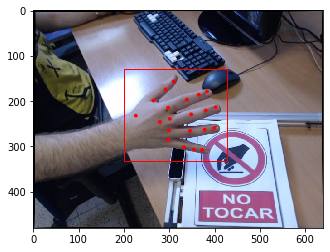

In [11]:
display_image(image_arr,785)

In [12]:
# iterate over in bounding_arr and find  boundding box that has max width
max_width=0
max_w_index=0
for i,box in enumerate(bounding_arr):
    if box[3]-box[1]>max_width:
        max_width=box[3]-box[1]
        max_index=i
print(max_width)  
print(bounding_arr[max_w_index])

[306.]
[[160.]
 [190.]
 [355.]
 [450.]]


In [13]:
#iterate over bounding_arr and find  boundding box that has max height

max_height=0
max_h_index=0
for i,box in enumerate(bounding_arr):
    if box[2]-box[0]>max_height:
        max_height=box[2]-box[0]
        max_h_index=i
print(max_height) 
print(bounding_arr[max_h_index])

[275.]
[[118.]
 [258.]
 [393.]
 [455.]]


In [15]:
# We crop hand with the aid of bounding box. Because out of bounding box image information is no sense for us.
#But each image has different height and width. We have to find max height and width in our images. 
#Cropped images is extend to max height and width to add zero values.
#Thus,our cropped image has same width and height values that also is max height and width
imagepad_arr=[]                           #create empty list to append our cropped and padding images
for index,image in enumerate(image_arr):  #iterate over image_array
    t,l,b,r=bounding_arr[index]           #find bounding box of the image
    t,l,b,r=int(t),int(l),int(b),int(r)   #convert this values to integer
    image_cropped=image_arr[index][t:b, l:r] #crop image accorting to bounding box values
    imagepad_arr.append(np.pad(image_cropped, ((0,int(max_height)-(b-t)),(0,int(max_width)-(r-l)),(0,0)), 'constant'))   #Cropped images is extend to max height and width to add zero values.
del image_arr                                #not need image_arr . we can delete it
imagepad_arr=np.array(imagepad_arr)        #convert list to numpy array 
print(imagepad_arr.shape)                  #print array shape
print(type(imagepad_arr))                  #print array type

(2832, 275, 306, 3)
<class 'numpy.ndarray'>


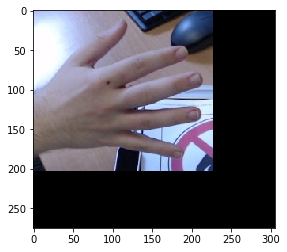

In [16]:
plt.imshow(imagepad_arr[785])              #display any image in imagepad_arr to prove success cropping and padding

In [18]:
#Until now,we adjusted our images.But still joint points of image did not adjust according to new images.
#Thus,our images shifted l unit to right and t unit to top.thing that we have to do is that  do same thing for joint points too.
for i,_ in enumerate(joint_arr):   #iterate over joint_arr
    t, l, b, r = bounding_arr[i]   #find bounding box of image
    joint_arr[i][:,0] = joint_arr[i][:,0] - int(l)  #change axis value of joint 
    joint_arr[i][:,1] = joint_arr[i][:,1] - int(t)  #change ordinate value of joint

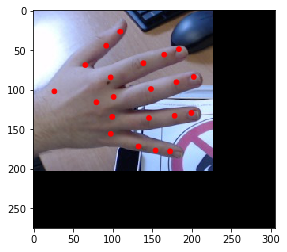

In [19]:
display_image(imagepad_arr,785,False)               #display image with new adjusted joints

In [20]:
#print all array shape for controlling dimensions
print(imagepad_arr.shape)
print(joint_arr.shape)
print(bounding_arr.shape)

(2832, 275, 306, 3)
(2832, 21, 2)
(2832, 4, 1)


In [21]:
#create dictionary to hold together all information
#Save this dictionary to utilize for modelling
mydict = {'image_arr': imagepad_arr,'joint_arr': joint_arr,'bounding_arr':bounding_arr}
with open('D:\\data_hand_pose.pickle','wb') as file_to_dump:
    pickle.dump(mydict,file_to_dump)